In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')


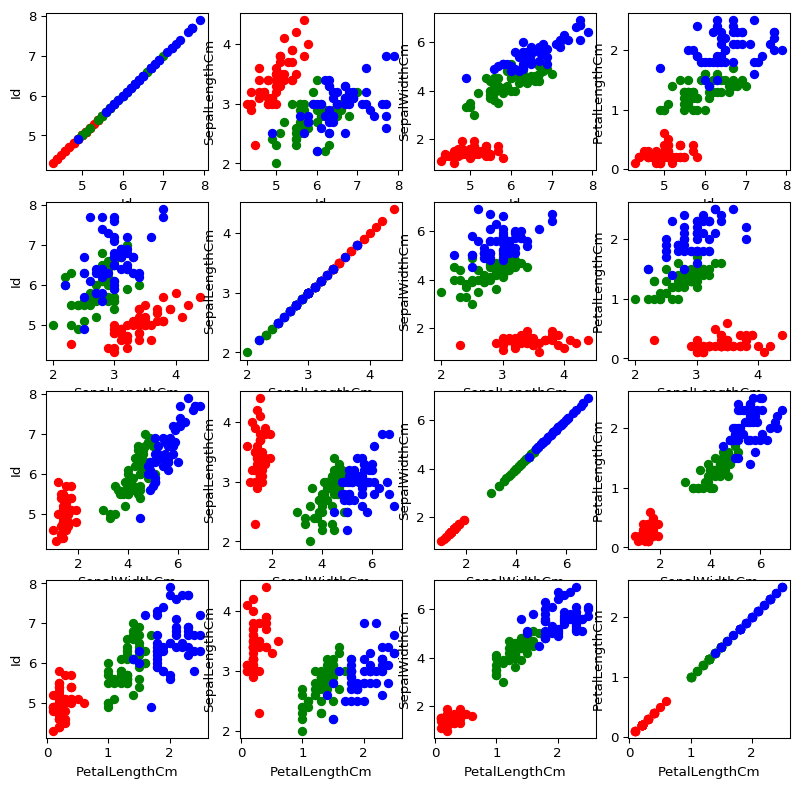

In [10]:
# Подгрузим датасет
src_df = pd.read_csv('Iris.csv')

print(src_df.columns)

# Оценим линейную разделимость объектов датасета
def linear_split(df):
    labels = list(df["Species"].unique())
    
    plt.figure(figsize=(10, 10), dpi=96)
    for i in range(4):
        for j in range(4):
            ax = plt.subplot(4, 4, i * 4 + j + 1)
            ax.set_xlabel(df.columns[i])
            ax.set_ylabel(df.columns[j])
            colors="rgb"

            for q, label in enumerate(labels):
                data = df[df.Species == label].values[:,1:5]
                ax.plot(data[:, i], data[:, j], "{}o".format(colors[q]))
                
linear_split(src_df)

In [11]:
df = src_df.copy()

# Добавим столбец, содержащий числовой индекс
# значения в столбце Species. Он будет выходом FFNN
df["label"] = df["Species"]
labels = list(df["Species"].unique())
labels = {label: i for i, label in enumerate(labels)}
df = df.replace(labels)

# Извлечём из датасета колонки, содержащие
# параметрические данные объектов 
X = df.values[:, 1:5]

# Извлечём колонку с индексами видов
Y = df["label"]
Y = to_categorical(Y)

# Генерируем набор случайных индексов записей
# для обучения сети и для валидации
train_indices = random.sample(range(len(df)), int(0.9 * len(df)))
test_indices = list(set(range(len(df))) - set(train_indices))

x_train = X[train_indices]
y_train = Y[train_indices]

x_test = X[test_indices]
y_test = Y[test_indices]

In [19]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam, SGD

'''
В качестве архитектуры нс для решения задачи
возьмём deep FFNN - keras.models.Sequential,
которая принимает на вход 4 признака и
пропускает их через 3 слоя с 10, 6 и 3 нейронами
на выходе.

Активационные функции на скрытых слоях - простые ReLU, 
на выходе - softmax, необходимая для обучения сети,
выполняющей классификацию объектов по категориям.
'''
inputs = Input(shape=(4,))
x = Dense(10, input_shape=(4,), activation="relu")(inputs)
x = Dense(6, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

model = Model(
    inputs=inputs,
    outputs=x
)

'''
Обучение SGD в качестве алгоритма оптимизации
не показывает 100% разделения датасета при
длительности обучения до 2000 эпох.

Обучение с адаптивным алгоритмом оптимизации
Adam достигает 100% разделения объектов датасета
за 500-2000 эпох
'''
optimizer=SGD(lr=0.0003, momentum=0.95)
optimizer=Adam(lr=0.0003)

'''
В качестве метрики на столь малом датасете вполне
можно выбрать categorial_accuracy, показывающей
процент верно классифицированных объектов
'''
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 21        
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from time import strftime, localtime

mark=strftime("%Y-%m-%d_%H-%M-%S", localtime())

model.fit(
    x=X,
    y=Y,
    validation_split=0.1,
    batch_size=32,
    epochs=2000,
    shuffle=True,
    callbacks=[
        TensorBoard(log_dir="iris-{}".format(mark))
    ],
    verbose=False
)

In [23]:
y_pred = model.predict(X)
y_res = (y_pred.argmax(axis=1) == Y.argmax(axis=1)).sum() / len(y_pred)
print("Full dataset accuracy: %.3f" % y_res)

Full dataset accuracy: 0.973
